# Feature Selection

A discussion that often comes up doing applied Machine Learning work is whether and how to perform do feature selection. In this post, I will consider two standard justifications offered for doing so and evaluate whether they make sense. In many ways, this discussion centers on one of the core tradeoffs in Supervised Learning: does increasing predictive accuracyccomes at the expense of reducing interpretability?

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score, brier_score_loss, log_loss, average_precision_score
import matplotlib.pyplot as plt
import os

In [2]:
os.chdir('../models')

In [3]:
df = pd.read_csv('metrics.csv')

## Improve model accuracy?


The typical way bias-variance tradeoff is introduced in textbooks and courses is in the context of linear regression. The story goes as follows: you can reduce in-sample error to a point as arbitrarily low as
possible by increasing the number of parameters in your model. However, when you try to use the same model to predict out of sample
your accuracy is going to be much lower. This is because the extra parameters get tuned to the in-sample noise and
when you get data that doesn't contain the same noise they don't work so well. The suggested remedy is to regularize
your model using ridge, lasso or a combination of the two called elastic net. Regularization proceeds by shrinking
the coefficients of certain variables to very small values(ridge and elastic net) or zero (lasso) by imposing a 
constraint on how big the L2 (squared sum) or L1 (absolute sum) of the coefficients can get.

But is this true in the case of non-parametric models like Random Forests as well? Although I wasn't able to find 
any formal work that addresses this specific question (suggestions welcome), it's possible that it doesn't. One
reason might be that during the fitting of each tree a certain number of variables are dropped. The overfitting
problem in the context of Random Forests comes from growing a tree that is too deep or requiring too few samples fall
into each leaf of the tree. This can be dealt with by ensembling together many trees so that the variance of the overall
estimator is smaller than that for any individual estimator.

I trained a Random Forest classifier following the standard Machine Learning workflow on a [banking dataset from a 
Portugese bank](https://archive.ics.uci.edu/ml/datasets/Bank+Marketing) that analyzed the effect of telemarketing campaigns on whether contacted customers subcribed to
the product being marketed. I tried the model with the following four variations:

- a base model without variable selection
    
- using Variance Inflation factor for variable selection
    
- using Hierarchical Clustering for variable selection
    
- using a mix of 2 and 3, where numerical variables were selected by VIF and categorical variables by 3.
    
Four metrics obtained from these models are presented below.

## What is Collinearity?

- In the most basic sense a variable is considered collinear if it can be written as a linear combination of
other variables. In Linear Regression world this becomes a problem because it blows up your standard errors as
it is not possible to attribute variation in the output variable to the collinear variables based on the given 
data alone. In some ways this is a problem with the dataset and people worrying about it are confusing the property
of the dataset with the properties of the model. For a more comprehensive discussion consider reading [this](https://janhove.github.io/analysis/2019/09/11/collinearity) and [this](https://davegiles.blogspot.com/2011/09/micronumerosity.html?m=1).

- Variance Inflation Factor is a metric that allows you to quantify how much of the variation in one variable
is explained by other covariates. This can be obtained by regressing each variable on the complement set and
getting R-squared for each. VIF is defined as $\frac {1}{1-R_{i}^2}$ Typical Feature Selection routines using VIF use some threshold of VIF to drop variables.

- Hierarchical Clustering using Spearman's Rank Correlation allows us to learn about dependencies between not just
numerical features but also categorical features and also allows us to model non-linear dependencies. A typical
routine using Hierarchical Clustering first fits a model, gets variable importances, gets Hierarchical cluster 
memberships and decides to drop the least important members of each cluster.

In [4]:
df.index = ['roc_auc', 'precision', 'log_loss', 'brier_score']
df.columns = ['vif', 'hclust', 'mixed', 'base']

Text(0.5,0.98,'Comparison of various feature selection methods on classification metrics')

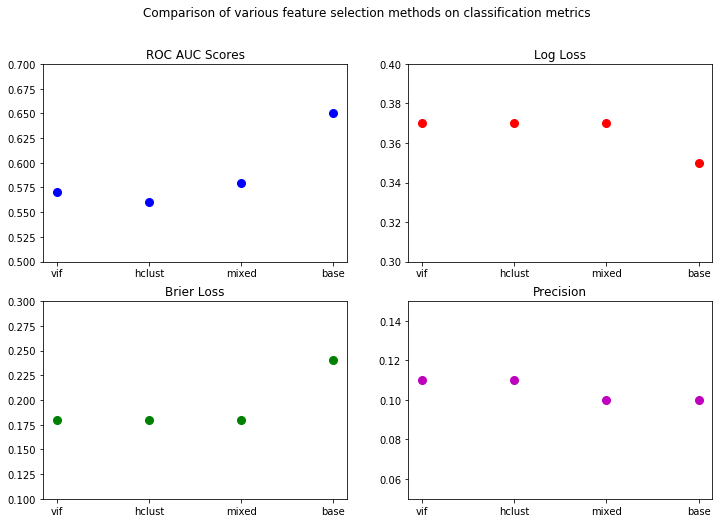

In [15]:
fig, ax = plt.subplots(2, 2, figsize=(12, 8))

ax[0,0].plot(df.columns, df.loc['roc_auc'], 'bo', markersize = 8)
ax[0,0].set_ylim(0.5, 0.7)
ax[0,0].title.set_text('ROC AUC Scores')

ax[0,1].plot(df.columns, df.loc['log_loss'], 'ro', markersize = 8)
ax[0,1].set_ylim(0.3, 0.4)
ax[0,1].title.set_text('Log Loss')

ax[1,0].plot(df.columns, df.loc['brier_score'], 'go', markersize = 8)
ax[1,0].set_ylim(0.1, 0.3)
ax[1,0].title.set_text('Brier Loss')

ax[1,1].plot(df.columns, df.loc['precision'], 'mo', markersize = 8)
ax[1,1].set_ylim(0.05, 0.15)
ax[1,1].title.set_text('Precision')

fig.suptitle('Comparison of various feature selection methods on classification metrics')

From looking at the results above it doesn't appear as if variable selection improves model performance.
Infact it seems as if having more variables results in better performance. Of course this is just one dataset and
a more comprehensive assessment would repeat the same process over several datasets.

## Improve Interpretability?

Unless you're building a system where accuracy is all that matters, you don't care about accuracy alone. Models need
to be interpretable. Interpretability means different things to different people and several different use cases
are commonly lumped together. These might be as follows:

- the end user should be able to understand *how* the model arrived at a prediction

- the end user should be able to trust that the model is giving the right amoung of importance to the 
right variables in arriving at a prediction

- the modeler should be able to debug the model if it starts making predictions that don't seem correct

- the end user should be able to derive recommendations for actions from the model.
    
Having fewer variables in a model helps on all four counts but it doesn't completely address all these issues.

- Business recommendations could be derived from such a model by stratifying the population based on features the
model considers important for prediction and applying business rules for taking the action relevant for optimizing the business metric under consideration. If these variables are non-overlapping, it is probably easier to apply this procedure.

- Having fewer and uncorrelated variables doesn't shed any insight into the mechanism for arriving at the
prediction.

- Having fewer and uncorrelated variables changes how Random Forest default importance measure.  Below are
the default variable importance measures from the model:


In [6]:
df_imp = pd.read_csv('importance_comps.csv')

In [7]:
df_imp.sort_values(by = 'base', ascending = False, inplace = True)

Text(0.5,0.98,'Variable Importance Comparison')

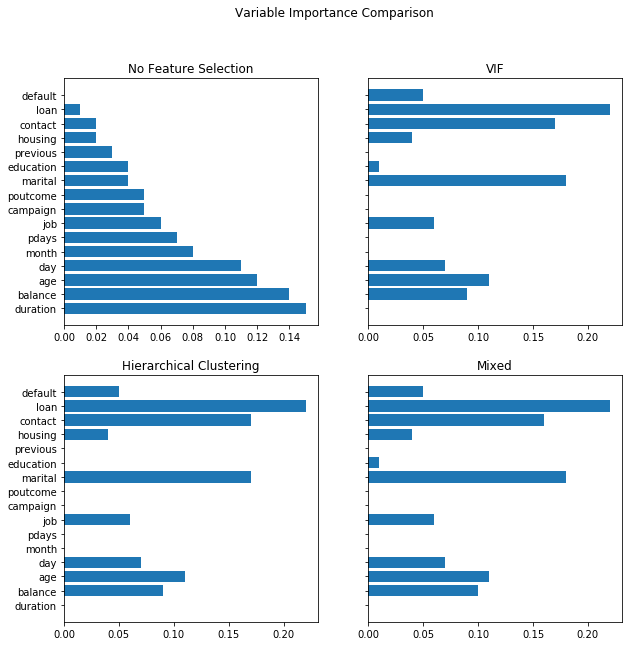

In [8]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10), sharey=True)
axs[0,0].barh(df_imp['feature'], df_imp['base'])
axs[0,0].title.set_text('No Feature Selection')
#axs[0,0].set_xlim(0, 0.2)

axs[0,1].barh(df_imp['feature'], df_imp['vif_score'])
axs[0,1].title.set_text('VIF')
#axs[0,1].set_xlim(0, 0.2)

axs[1,0].barh(df_imp['feature'], df_imp['hclust_score'])
axs[1,0].title.set_text('Hierarchical Clustering')
#axs[1,0].set_xlim(0, 0.2)

axs[1,1].barh(df_imp['feature'], df_imp['mixed'])
axs[1,1].title.set_text('Mixed')
#axs[1,1].set_xlim(0, 0.2)

fig.suptitle('Variable Importance Comparison')

The base model considers duration of the call to the most important measure but duration is not known before a
call is performed and moreover after the call the outcome is already known. Including this variable in the model is
an example of data leakage. Below are feature importances for all four cases obtained after removing 'duration'
from the dataset.


In [9]:
df_imp_adj = pd.read_csv('importance_comps_adj.csv')

In [10]:
df_imp_adj.sort_values(by = 'base', ascending = False, inplace = True)

Text(0.5,0.98,'Variable Importance Comparison')

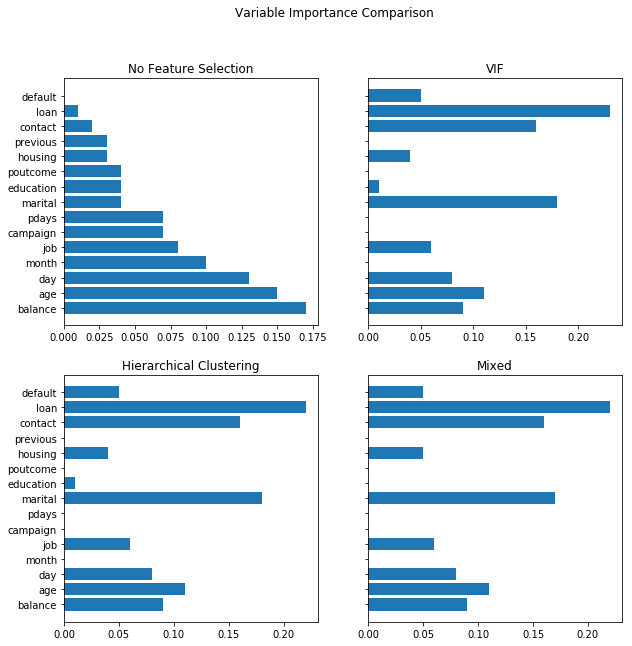

In [11]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10), sharey=True)
axs[0,0].barh(df_imp_adj['feature'], df_imp_adj['base'])
axs[0,0].title.set_text('No Feature Selection')
#axs[0,0].set_xlim(0, 0.2)

axs[0,1].barh(df_imp_adj['feature'], df_imp_adj['vif_score'])
axs[0,1].title.set_text('VIF')
#axs[0,1].set_xlim(0, 0.2)

axs[1,0].barh(df_imp_adj['feature'], df_imp_adj['hclust_score'])
axs[1,0].title.set_text('Hierarchical Clustering')
#axs[1,0].set_xlim(0, 0.2)

axs[1,1].barh(df_imp_adj['feature'], df_imp_adj['mixed'])
axs[1,1].title.set_text('Mixed')
#axs[1,1].set_xlim(0, 0.2)

fig.suptitle('Variable Importance Comparison')

The three models that implement feature selection methods consider the categorical feature 'loan', indicating
whether the person has a personal loan or not, to be the most important feature followed by the person's marital
status and the type of communicaation method used while the base model considers the balance in their account to
be the most important variable followed by their age and the date on which they were contacted. This is confusing.
Two different people using different variable importance measures and interpreting them as actionable insights 
might end up taking completely different actions. So which one should we trust?

In this [in-depth study](https://explained.ai/rf-importance/index.html) of default variable importances in the case of RandomForests it was found that default
variable importances can be biased, especially for features that vary in their scale of measurement or the number
of their categories. Instead they recommend using a different importance measure using permutation feature importance. This procedure involves permuting a feature's values randomly and seeing how much drop-off there is in predictive accuracy. For a more comprehensive discussion please read the article.

Feature importances only tell you about variables a model considered important. They don't tell you the 
magnitude of dependence of the output on that feature and not even the direction. In order to obtain these kinds
of partial dependences you might want to look into the interpretability literature and consider methods such as
[Partial Dependence Plots](https://christophm.github.io/interpretable-ml-book/pdp.html), [LIME](https://christophm.github.io/interpretable-ml-book/lime.html) and [Shap values](https://christophm.github.io/interpretable-ml-book/shap.html). In order to derive a recommendation from this model you might want to think about the kind of actions you want to take and what kind of effects they might have on the outcome but this requires estimating the counterfactual, i.e. making predictions under intervention and that is a [totally different analysis altogether](https://projecteuclid.org/download/pdfview_1/euclid.ssu/1255440554).

## In conclusion:

1) Feature selection methods may not give you a lift in accuracy.

2) They reduce the number of features and decorrelate them but they don't help you interpret the model in any
useful way for making actionable business recommendations.

3) The main reason to interpret models is to make causal inferences. Standard remedies for measuring collinearity won't help you do that.  If all you care about is prediction, you can just use regularization. If you want to make causal inferences about effects of a variable, while it is useful to notice you don't have much variation in that variable conditional on another variable, you should still condition on it.

All the code that goes with this post is available on [this github repository](https://github.com/vonarchimboldi/Projects/tree/master/mlprojects/mlframework). 